# Functions (load data, plot simple)

In [271]:
import pandas as pd
import numpy as np
from numpy.linalg import svd, eig
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from matplotlib.pyplot import imshow
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import numpy.random as rand
from itertools import islice
from sklearn.ensemble import (GradientBoostingRegressor, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              RandomForestClassifier,
                             RandomForestRegressor)
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
import math
import sklearn.datasets as datasets
# import sklearn.cross_validation as cv
import sklearn.model_selection as cv
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import log_loss, make_scorer, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

import ndjson

plt.style.use('ggplot')

%matplotlib inline

In [2]:
# load the npy and ndjson data
def load_data():
    faces = np.load('data/face.npy')
    eyes = np.load('data/eye.npy')
    with open('data_simplified/full_simplified_face.ndjson') as f:
        temp = ndjson.load(f)
    face_df = pd.DataFrame.from_dict(temp)
    with open('data_simplified/full_simplified_eye.ndjson') as j:
        temp1 = ndjson.load(j)
    eye_df = pd.DataFrame.from_dict(temp1)
    return faces, eyes, face_df, eye_df

In [3]:
# merge npy and ndjson data
def merge(df, npy):
    df['npy'] = list(npy)

In [4]:
# sampling only if it was recognized by the system
def sample_it(df, n):
    df_out = df[df['recognized'] == True].sample(n=n, replace=True)
    return df_out

In [5]:
def clean_merge_it(df, df1):
    df = df.drop(['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp'], axis=1)
    df1 = df1.drop(['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp'], axis=1)
    return pd.concat([df, df1], join='inner', ignore_index=True)

In [6]:
# plots a 1x10 of an image

def plot_simple(data, name):
    fig, axs = plt.subplots(1,10, figsize=(10,1))

    for thing, ax in zip(data, axs.flatten()):
        image = thing.reshape(28, 28)
        ax.imshow(image, cmap=cm.Greys)
        ax.axis('off')
        
    fig.savefig('images/{}.png'.format(name), bbox_inches='tight')

In [7]:
def plot_stroke(data):
    fig, axes = plt.subplots(1,10, figsize=(10,1))
    axes = axes.ravel()

    for i, example in enumerate(data):
        if i == 10:
                break
        for x,y in example:
            axes[i].plot(x, y, marker='.')
            axes[i].axis('off')
#     plt.gca().invert_yaxis()

# plot_stroke(face_df['drawing'])

In [8]:
def score_matrix(obj):
    name = str(obj.__class__).split(".")[-1][:-2]
    score = obj.score(X_test,y_test)
    y_pred = obj.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    precision = tp / (tp +fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print("Model: {}".format(name))
    print("precision = {:.2%}".format(precision))
    print("recall = {:.2%}".format(recall))
    print('accuracy = {:.2%}, score = {:.2%}'.format(accuracy,score))
    return score

In [9]:
# load the data
faces, eyes, face_df, eye_df = load_data()

# merge the npy with df
merge(face_df, faces)
merge(eye_df, eyes)

# sample subset of data
sample_face = sample_it(face_df, 5000)
sample_eye = sample_it(eye_df, 5000)

# merged sample and cleaned
df = clean_merge_it(sample_face, sample_eye)

# split npy to (10000,784)
df2 = pd.DataFrame(df.npy.tolist())

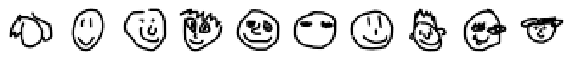

In [10]:
plot_simple(df['npy'], 'test')

# Plot True and False

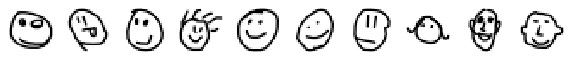

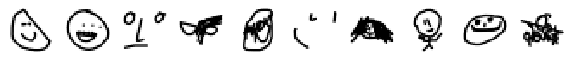

In [11]:
# plot true FACES
face_true = face_df[face_df['recognized'] == True]['npy']
plot_simple(face_true, 'row_true_faces')

# plot false FACES
face_false = face_df[face_df['recognized'] == False]['npy']
plot_simple(face_false, 'row_false_faces')

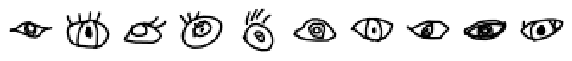

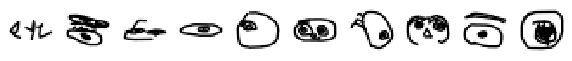

In [12]:
# plot true EYES
eye_true = eye_df[eye_df['recognized'] == True]['npy']
plot_simple(eye_true, 'row_true_eyes')

# plot false EYES
eye_false = eye_df[eye_df['recognized'] == False]['npy']
plot_simple(eye_false, 'row_false_eyes')

# Exploratory Data Analysis

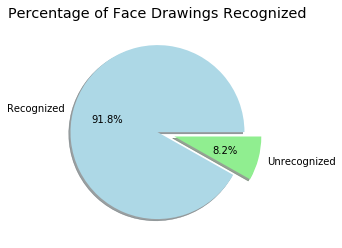

In [13]:
label = ('Recognized', 'Unrecognized')

plt.pie(face_df['recognized'].value_counts(),
        labels=label,
       explode=(0, 0.2),
       autopct= '%1.1f%%',
        shadow=True, 
       colors=('lightblue', 'lightgreen'))
plt.title('Percentage of Face Drawings Recognized');

plt.savefig('images/pie_face_drawings.png', bbox_inches='tight')

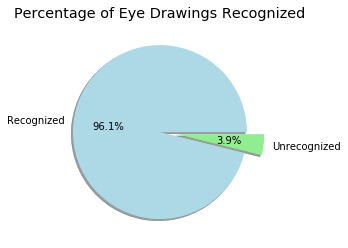

In [14]:
label = ('Recognized', 'Unrecognized')

plt.pie(eye_df['recognized'].value_counts(),
        labels=label,
       explode=(0, 0.2),
       autopct= '%1.1f%%',
        shadow=True, 
       colors=('lightblue', 'lightgreen'))
plt.title('Percentage of Eye Drawings Recognized');

plt.savefig('images/pie_eye_drawings.png', bbox_inches='tight')

# Prep the Models

In [221]:
# 0 = face | 1 = eye
X = df2
y = df['word'].replace({'face': 0, 'eye': 1}).to_numpy()

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state=123, 
                                                   test_size=0.2)

# Principle Component Analysis

In [179]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(2)
p_comp = pca.fit_transform(X)
p_df = pd.DataFrame(data = p_comp
             , columns = ['principal component 1', 'principal component 2'])
final_df = pd.concat([p_df, df['word'].replace({'face': 0, 'eye': 1})], axis=1)

In [183]:
# final_df
pca.explained_variance_ratio_

array([0.09873772, 0.03930287])

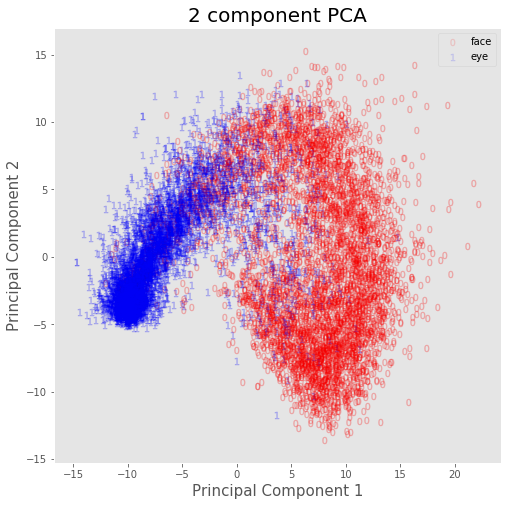

In [272]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0, 1]
for target, color in zip(targets,colors):
    ax.scatter(final_df['principal component 1'][:5000]
               , final_df['principal component 2'][:5000]
               , c = 'r'
               , s = 50
               , alpha=0.1
               , marker=('$0$'))
    ax.scatter(final_df['principal component 1'][5000:]
               , final_df['principal component 2'][5000:]
               , c = 'b'
               , s = 50
               , alpha=0.1
               , marker=('$1$'))
ax.legend(['face', 'eye'])
ax.grid()

# 3d Principal Component

In [248]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(3)
p_comp = pca.fit_transform(X)
p_df = pd.DataFrame(data = p_comp
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
final_df = pd.concat([p_df, df['word'].replace({'face': 0, 'eye': 1})], axis=1)

<IPython.core.display.Javascript object>


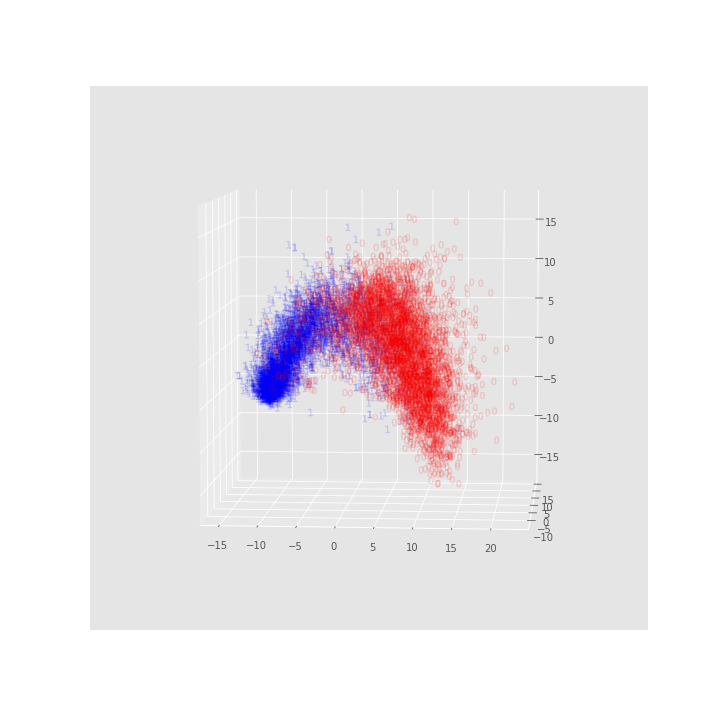

In [273]:
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")


ax.scatter3D(final_df['principal component 1'][:5000]
               , final_df['principal component 2'][:5000]
               , final_df['principal component 3'][:5000]
               , c = 'r'
               , s = 50
               , alpha=0.1
               , marker=('$0$'))
ax.scatter3D(final_df['principal component 1'][5000:]
               , final_df['principal component 2'][5000:]
               , final_df['principal component 3'][5000:]
               , c = 'b'
               , s = 50
               , alpha=0.1
               , marker=('$1$'))

for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

plt.show()

# Prep Data for Classifiers

In [223]:
scaler = StandardScaler()

# fit on training only
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# minimum number of principal components such that 95% of variance retained
pca = PCA(0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Logistic Regression Classifier

In [224]:
lrc = LogisticRegression()
lrc_func = lrc.fit(X_train, y_train)

score_matrix(lrc_func)

/Users/AaronLee/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model: LogisticRegression
precision = 92.65%
recall = 93.94%
accuracy = 93.20%, score = 93.20%


0.932

### Decision Tree Classifier

In [225]:
dtc = DecisionTreeClassifier()
dtc_func = dtc.fit(X_train, y_train)

score_matrix(dtc_func)

Model: DecisionTreeClassifier
precision = 90.07%
recall = 89.26%
accuracy = 89.65%, score = 89.65%


0.8965

### Random Forest Classifier

In [226]:
rfc = RandomForestClassifier()
rfc_func = rfc.fit(X_train, y_train)

score_matrix(rfc_func)

/Users/AaronLee/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model: RandomForestClassifier
precision = 95.02%
recall = 85.29%
accuracy = 90.35%, score = 90.35%


0.9035

### Gradient Boosting Classifier

In [227]:
gbc = GradientBoostingClassifier()
gbc_func = gbc.fit(X_train, y_train)

score_matrix(gbc_func)

Model: GradientBoostingClassifier
precision = 93.88%
recall = 91.55%
accuracy = 92.75%, score = 92.75%


0.9275